In [ ]:
# Install required libraries
!pip install scikit-learn==1.1.3
!pip install mrmr_selection
!pip install scikit-survival
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 38.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 4.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 119.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3
Looking in indexes: https://pyp

In [ ]:
# Import libraries for feature scaling and selection, fitting and  evaluation of the survival model
import sksurv
import mrmr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sksurv.svm import FastSurvivalSVM
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.exceptions import FitFailedWarning
import warnings

from mrmr import mrmr_classif
from numpy import mean


%matplotlib inline

color_pal = sns.color_palette()
plt.style.use('seaborn')


In [ ]:
# Connect to google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load flux data 
file1 = pd.read_csv('/content/drive/MyDrive/Data/fluxes.csv')

# Load gene expression data 
file2 = pd.read_csv('/content/drive/MyDrive/Data/gene_expression_data.csv')

# Load survival data
file3 = pd.read_csv('/content/drive/MyDrive/Data/survival_data.csv')

### **Experiment 1:** Survival Analysis with Fluxes Data

In [ ]:
# Load flux data as the X variable
X_flux = file1
# Load survival data as the Y variable
Y = file3

In [ ]:
#Preview data
X_flux.head()

,fluxes1,fluxes2,fluxes3,fluxes4,fluxes5,fluxes6,fluxes7,fluxes8,fluxes9,fluxes10,...,fluxes3779,fluxes3780,fluxes3781,fluxes3782,fluxes3783,fluxes3784,fluxes3785,fluxes3786,fluxes3787,fluxes3788
0,0,0,0.000000e+00,0,0,0,0,-9.568776,0,0,...,0,0,0,0,0.0,0,0,0,0,0
1,0,0,0.000000e+00,0,0,0,0,-12.470839,0,0,...,0,0,0,0,0.0,0,0,0,0,0
2,0,0,2.973557e-15,0,0,0,0,-66.158158,0,0,...,0,0,0,0,0.0,0,0,0,0,0
3,0,0,0.000000e+00,0,0,0,0,8.613825,0,0,...,0,0,0,0,0.0,0,0,0,0,0
4,0,0,0.000000e+00,0,0,0,0,-63.602923,0,0,...,0,0,0,0,0.0,0,0,0,0,0


In [ ]:
#Preview data
Y.head()

,PatientID,Time,Event
0,TCGA-A1-A0SD-01A-11R-A114-1,437,0
1,TCGA-A2-A04N-01A-11R-A114-1,3153,0
2,TCGA-A2-A04U-01A-11R-A114-1,670,0
3,TCGA-A2-A04W-01A-31R-A114-1,1918,0
4,TCGA-A2-A0CL-01A-11R-A114-1,1827,0


In [ ]:
#Check shape of variables
print(X_flux.shape)
print(Y.shape)

(105, 3788)
(105, 3)


In [ ]:
#Check for missing values
print(X_flux.isnull().sum())
print(Y.isnull().sum())

fluxes1       0
fluxes2       0
fluxes3       0
fluxes4       0
fluxes5       0
             ..
fluxes3784    0
fluxes3785    0
fluxes3786    0
fluxes3787    0
fluxes3788    0
Length: 3788, dtype: int64
PatientID    0
Time         0
Event        0
dtype: int64


In [ ]:
# Normalise data
ss = MinMaxScaler()
X_norm = X_flux
X_norm = pd.DataFrame(ss.fit_transform(X_norm), columns=X_norm.columns)

In [ ]:
# Feature Selection using MRMR
y_mrmr = Y['Time']

features_selected = mrmr_classif(X_norm, y_mrmr, K = 50)
X_mrmr_f = X_flux[features_selected]

100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


In [ ]:
# Check selected features
X_flux[features_selected].columns

Index(['fluxes3', 'fluxes14', 'fluxes17', 'fluxes24', 'fluxes29', 'fluxes34',
       'fluxes64', 'fluxes71', 'fluxes75', 'fluxes77', 'fluxes78', 'fluxes82',
       'fluxes88', 'fluxes95', 'fluxes104', 'fluxes107', 'fluxes109',
       'fluxes114', 'fluxes115', 'fluxes117', 'fluxes119', 'fluxes122',
       'fluxes123', 'fluxes141', 'fluxes144', 'fluxes152', 'fluxes156',
       'fluxes159', 'fluxes161', 'fluxes166', 'fluxes167', 'fluxes171',
       'fluxes174', 'fluxes179', 'fluxes180', 'fluxes181', 'fluxes182',
       'fluxes183', 'fluxes192', 'fluxes195', 'fluxes196', 'fluxes208',
       'fluxes216', 'fluxes217', 'fluxes223', 'fluxes225', 'fluxes226',
       'fluxes231', 'fluxes237', 'fluxes239'],
      dtype='object')

In [ ]:
# Check shape for predictor variables
X_mrmr_f.shape

(105, 50)

In [ ]:
# Prepare target variable

Y['Event'] = Y['Event'].astype('bool')

Y['Time'] = Y['Time'].astype('float')

Y = Y[['Event','Time']].to_records(index=False)

In [ ]:
## Compare Machine Learning Methods for Survival Analysis


# Set up seed and the options for the cross-validation approach
SEED = 5
CV = KFold(n_splits=5, shuffle=True, random_state=0)

# Split the data set into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mrmr_f, Y, test_size=0.2, 
                                                    stratify=Y['Event'],
                                                    random_state=SEED)

In [ ]:
# Define a function for grid search to tune training model and predict the results
def grid_search(estimator, param, X_train, y_train, X_test, y_test, CV):
    
    # Define Grid Search
    gcv = GridSearchCV(
    estimator,
    param_grid=param,
    cv=CV,
    n_jobs=-1).fit(X_train, y_train)

    # Find best model
    model = gcv.best_estimator_
    print(model)
    
    # Predict model
    prediction = model.predict(X_test)
    result = concordance_index_censored(y_test['Event'], y_test['Time'], prediction)
    print('C-index for test set (Hold out):', result[0])

    return [model,  prediction]

# Define function to re-run experiment 20 times 
def c_index(model, X, y, n=20):
    np.random.seed(1)
    seeds = np.random.permutation(1000)[:n]

    # Train and evaluate model with 20 times
    cindex_score = []
    predict_list = []
    
    for s in seeds:
        X_trn, X_test, y_trn, y_test = train_test_split(X, y, test_size=0.2, 
                                                        stratify=y['Event'],
                                                        random_state=s)
        model.fit(X_trn, y_trn)
        prediction = model.predict(X_test)
        predict_list.append(prediction)
        result = concordance_index_censored(y_test['Event'],y_test['Time'], prediction)
    
        cindex_score.append(round(result[0],3))

    print('Average C-index for {} runs'.format(n), np.mean(cindex_score))
    
    return [cindex_score, predict_list]

In [ ]:
# Set pipeline and param grid

# CoxnetSurvivalAnalysis
pipe_coxnet = Pipeline([('scaler', MinMaxScaler()),('model', CoxnetSurvivalAnalysis())])
param_coxnet ={'scaler': [MinMaxScaler()],
            'model__alpha_min_ratio': [0.01, 0.001, 0.0001],
            'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
            'model__n_alphas': [50, 100, 150],
            'model__max_iter': [10000, 50000, 100000]}

# CoxPHSurvivalAnalysis
pipe_coxPH = Pipeline([('scaler', MinMaxScaler()),('model', CoxPHSurvivalAnalysis())])
param_coxPH ={'scaler': [MinMaxScaler()],
        "model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}
            
# Random Survival Forest
pipe_rsf = Pipeline([('scaler', MinMaxScaler()),('model', RandomSurvivalForest())])
param_rsf ={'scaler': [MinMaxScaler()],
        'model__random_state': [SEED],
        'model__max_features': ['sqrt'],
        'model__max_depth': [8],
        'model__min_samples_leaf': [50, 100],
        'model__min_samples_split': [100],
        'model__n_estimators':[500]}

# Gradient Boost Survival
pipe_gbs = Pipeline([('scaler', MinMaxScaler()),('model', GradientBoostingSurvivalAnalysis())])
param_gbs ={'scaler': [MinMaxScaler()],
        'model__random_state': [SEED],
        'model__learning_rate': [0.01, 0.1, 1],
        'model__n_estimators':[200, 500, 800, 1000]}

# Survival SVM
pipe_svm = Pipeline([('scaler', MinMaxScaler()),('model', FastSurvivalSVM())])
param_svm ={'scaler': [MinMaxScaler()],
        'model__random_state': [SEED],
        'model__max_iter': [500, 5000],
        'model__optimizer':['avltree', 'rbtree','simple']}

# Estimator list:
estimator_list = {'Coxnet Regression':[pipe_coxnet, param_coxnet ],
                'CoxPH Regression':[pipe_coxPH, param_coxPH ],  
                'Random Forest Survival':[pipe_rsf, param_rsf], 
                'Gradient Boosting Survival': [pipe_gbs, param_gbs], 
                'SVM Survival': [pipe_svm, param_svm]}

In [ ]:
# Compare model performance with grid search
model_list = []
pred_list = []
c_index_list = []
pred_list_n = []

for model_name, index in estimator_list.items():
    print('\n',model_name)
    estimator = index[0]
    param = index[1]
    outcome = grid_search(estimator, param, X_train, y_train, X_test, y_test, CV)
    model = outcome[0]
    model_list.append(model)
    pred_list.append(outcome[1])

    # Run model n times to check c-index
    score, pre = c_index(model, X_mrmr_f, Y, n=20)
    c_index_list.append(score)
    pred_list_n.append(pre)


 Coxnet Regression
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.1,
                                        max_iter=10000, n_alphas=50))])
C-index for test set (Hold out): 0.6666666666666666
Average C-index for 20 runs 0.52525

 CoxPH Regression
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model', CoxPHSurvivalAnalysis(alpha=0.001))])
C-index for test set (Hold out): 0.6666666666666666
Average C-index for 20 runs 0.58425

 Random Forest Survival
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 RandomSurvivalForest(max_depth=8, min_samples_leaf=50,
                                      min_samples_split=100, n_estimators=500,
                                      random_state=5))])
C-index for test set (Hold out): 0.5
Average C-index for 20 runs 0.5

 Gradient Boosting Survival
Pipeline(steps=[('scaler', MinMaxScaler()),
              

Text(0.5, 1.0, 'C-index for 20 runs')

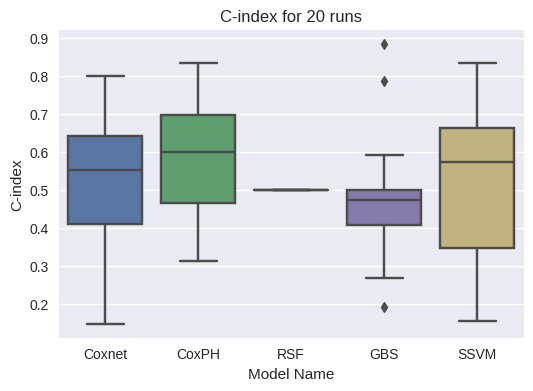

In [ ]:
# Visualise results

name = ['Coxnet', 'CoxPH', 'RSF', 'GBS', 'SSVM']
cv_res = []

for i in range(0,5):
    for c in c_index_list[i]:
        cv_res.append([name[i],c])

c_plot = pd.DataFrame(cv_res, columns=['Model Name','C-index'])

plt.subplots(figsize=(6,4))
ax = sns.boxplot(x="Model Name", y="C-index", data=c_plot)
plt.title('C-index for 20 runs')
 

In [ ]:
## Fine tune best performing model 

#Prepare hyperparameter  grid for  hyperparameter tuning
CoxPH_param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [ ]:
#Hyperparameter tuning with nested cross-validation

# Get copies of the fluxes dataset and target variables
Xf = X_mrmr_f
Yf = Y

# reset the index for data split
Xf = Xf.reset_index(drop=True)

# define the outer cross-validation loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# loop over the outer folds
outer_scores = []

for train_index, test_index in outer_cv.split(Xf, Yf):
    X_train, X_test = Xf.iloc[train_index], Xf.iloc[test_index]
    y_train, y_test = Yf[train_index], Yf[test_index]
    
    # define the inner cross-validation loop to tune the hyperparameters
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(CoxPHSurvivalAnalysis(), CoxPH_param_grid, cv=inner_cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # use the best hyperparameters to fit the model
    model = CoxPHSurvivalAnalysis(**grid_search.best_params_)
    model.fit(X_train, y_train)
    
    # evaluate the model on the test set
    score = model.score(X_test, y_test)
    outer_scores.append(score)

# print the mean score across the outer folds
print("Mean C-index: {:.3f}".format(np.mean(outer_scores)))

Mean C-index: 0.742


In [ ]:
# Print attributes from grid search
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: ", grid_search.best_score_)

Best hyperparameters:  {'alpha': 0.1}
Best mean cross-validation score:  0.653452380952381


In [ ]:
#Get best estimator from grid search
fluxes_model = grid_search.best_estimator_

In [ ]:
# Use the trained model to make predictions on the test set
y_pred = fluxes_model.predict(X_test)

In [ ]:
# Calculate the concordance index to evaluate the model's performance
ci = concordance_index_censored(y_test['Event'], y_test['Time'], y_pred)
print("Concordance index: {:.3f}".format(ci[0]))

Concordance index: 0.712


**Derive the relative risk interpretation from coefficients of features subset returned from model.**

Number of non-zero coefficients: 38


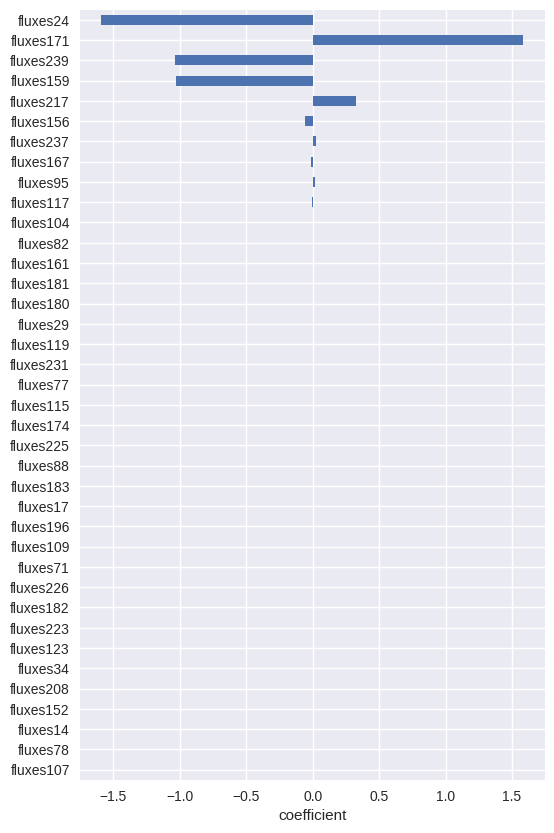

In [ ]:
# Plot to show selected risk factors and their level of importance
# Select features with non-zero coefficients
# Most important risk factors identified are 'fluxes24' and 'fluxes171'

best_coefs = pd.DataFrame(
    fluxes_model.coef_,
    index=Xf.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

Xf_non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = Xf_non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 10))
Xf_non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [ ]:
# Get relative risk of risk factors with exponetial of coefficients from model

"""
Cox model: h(t|xᵢ) = h₀(t)exp(βxᵢ) 
where exp(β) indicates the relative risk of adverse event given by a risk factor (covariate xᵢ),
For each covariate xᵢ, we can observe its coefficient β and relative risk exp(β).
exp(β) > 1 : an increased risk of event (death) [Most potent risk factor: fluxes171] 
exp(β) < 1 : a reduced risk of event [Most potent risk factor: fluxes24] 
"""

df = pd.DataFrame({
    'Risk Factor': Xf.columns,
    'Coefficient [β]': fluxes_model.coef_,
    'Relative Risk [exp(β)]': np.exp(fluxes_model.coef_),
})

# Round results to 3 decimal places
df = df.round({'Coefficient [β]': 3, 'Relative Risk [exp(β)]': 3})

# Sort by absolute value of coefficients
df = df.iloc[abs(df['Coefficient [β]']).argsort()[::-1]]

# Reset index
df = df.reset_index(drop=True)

df.head(10)

,Risk Factor,Coefficient [β],Relative Risk [exp(β)]
0,fluxes24,-1.596,0.203
1,fluxes171,1.586,4.883
2,fluxes239,-1.034,0.356
3,fluxes159,-1.027,0.358
4,fluxes217,0.328,1.389
5,fluxes156,-0.060,0.941
6,fluxes237,0.021,1.022
7,fluxes95,0.015,1.015
8,fluxes167,-0.015,0.986
9,fluxes117,-0.006,0.994


**Feature importance with SHAP values.**

In [ ]:
# Create a SHAP explainer object using the fitted model and the training data
explainer = shap.Explainer(fluxes_model.predict, X_train)

In [ ]:
# Calculate the SHAP values for a set of test instances
shap_values = explainer(X_test)

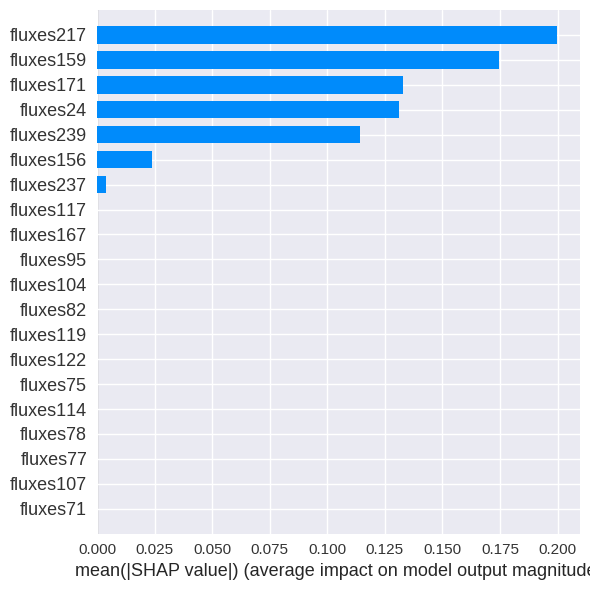

In [ ]:
# Plot the SHAP summary plot to visualize the overall feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(6,6))

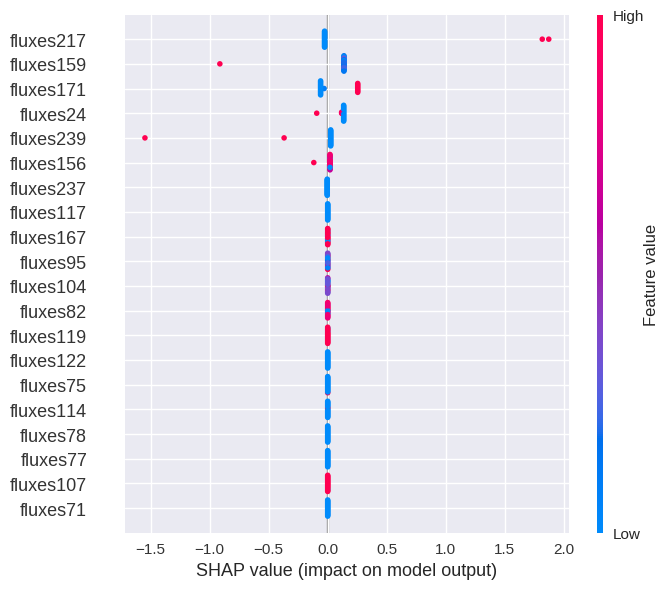

In [ ]:
# SHAP summary plot combining feature importance with feature effects
shap.summary_plot(shap_values, plot_size=(7,6))

### **Experiment 2:** Survival Analysis with Gene Expression Data

In [ ]:
# Load gene expression data as the X variable
X_gex = file2

#Rename unnamed (1st) column
X_gex = X_gex.rename(columns={X_gex.columns[0]: 'Risk_factor'})

# Tranpose patient ID  to rows in order to align gene data with fluxes data
X_gex = X_gex.set_index('Risk_factor').T.rename_axis('PatientID').rename_axis(None, axis=1).reset_index()

# Remove 'PatientID' column
X_gex = X_gex.drop(['PatientID'], axis=1)

In [ ]:
#Check for missing values
print(X_gex.isnull().sum())

AKAP5     0
G30       0
TMC3      0
OR51A2    0
HOXD4     0
         ..
GOT1L1    0
TRIM54    0
TRIT1     0
LRRC47    0
GATA1     0
Length: 17814, dtype: int64


In [ ]:
# Normalise data
ss = MinMaxScaler()
X_norm = X_gex
#X_norm = X_norm.drop(['PatientID'], axis = 1)
X_norm = pd.DataFrame(ss.fit_transform(X_norm), columns=X_norm.columns)

In [ ]:
# Feature Selection using MRMR
y_mrmr = Y['Time']

features_selected = mrmr_classif(X_norm, y_mrmr, K = 50)
X_mrmr_g = X_gex[features_selected]

100%|██████████| 50/50 [03:37<00:00,  4.35s/it]


In [ ]:
#Check selected features
X_gex[features_selected].columns

Index(['CCS', 'ARPC5', 'ANKRD10', 'ALOX12B', 'C10orf82', 'VENTXP1', 'ALPP',
       'MRLC2', 'ZNF79', 'CYP4V2', 'GSS', 'PLUNC', 'ACD', 'ATPAF1', 'ZNF324',
       'PAGE4', 'PCSK2', 'KRT20', 'NXF5', 'CAMSAP1', 'RPRML', 'GLIPR1L1',
       'UGT3A2', 'FCRL1', 'NXPH1', 'RASGRF1', 'OR2G2', 'GALNT2', 'MAGEB18',
       'TAS2R38', 'LRP1B', 'ZG16', 'SPDYA', 'METTL3', 'WBSCR18', 'DPP10',
       'GPATCH2', 'CLEC7A', 'C16orf73', 'SPRR1B', 'GLRA2', 'CRH', 'C20orf27',
       'C6orf145', 'SDHC', 'IL1RN', 'C6orf54', 'MGST1', 'MGC26647', 'HSFY1'],
      dtype='object')

In [ ]:
# Check shape for predictor variables
X_mrmr_g.shape

(105, 50)

In [ ]:
## Compare Machine Learning Methods for Survival Analysis

# Set up seed and the options for the cross-validation approach
SEED = 10
CV = KFold(n_splits=5, shuffle=True, random_state=0)

# Split the data set into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mrmr_g, Y, test_size=0.2, 
                                                    stratify=Y['Event'],
                                                    random_state=SEED)

In [ ]:
# Define a function for grid search to tune training model and predict the results
def grid_search(estimator, param, X_train, y_train, X_test, y_test, CV):
    
    # Define Grid Search
    gcv = GridSearchCV(
    estimator,
    param_grid=param,
    cv=CV,
    n_jobs=-1).fit(X_train, y_train)

    # Find best model
    model = gcv.best_estimator_
    print(model)
    
    # Predict model
    prediction = model.predict(X_test)
    result = concordance_index_censored(y_test['Event'], y_test['Time'], prediction)
    print('C-index for test set (Hold out):', result[0])

    return [model,  prediction]

# Define function to re-run experiment 20 times 
def c_index(model, X, y, n=20):
    np.random.seed(1)
    seeds = np.random.permutation(1000)[:n]

    # Train and evaluate model with 20 times
    cindex_score = []
    predict_list = []
    
    for s in seeds:
        X_trn, X_test, y_trn, y_test = train_test_split(X, y, test_size=0.2, 
                                                        stratify=y['Event'],
                                                        random_state=s)
        model.fit(X_trn, y_trn)
        prediction = model.predict(X_test)
        predict_list.append(prediction)
        result = concordance_index_censored(y_test['Event'],y_test['Time'], prediction)
    
        cindex_score.append(round(result[0],3))

    print('Average C-index for {} runs'.format(n), np.mean(cindex_score))
    
    return [cindex_score, predict_list]

In [ ]:
# Compare model performance with grid search
model_list = []
pred_list = []
c_index_list = []
pred_list_n = []

for model_name, index in estimator_list.items():
    print('\n',model_name)
    estimator = index[0]
    param = index[1]
    outcome = grid_search(estimator, param, X_train, y_train, X_test, y_test, CV)
    model = outcome[0]
    model_list.append(model)
    pred_list.append(outcome[1])

    # Run model n times to check c-index
    score, pre = c_index(model, X_mrmr_g, Y, n=20)
    c_index_list.append(score)
    pred_list_n.append(pre)


 Coxnet Regression
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.1,
                                        max_iter=10000, n_alphas=50))])
C-index for test set (Hold out): 0.9444444444444444
Average C-index for 20 runs 0.6716

 CoxPH Regression
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model', CoxPHSurvivalAnalysis(alpha=0.001))])
C-index for test set (Hold out): 0.9444444444444444
Average C-index for 20 runs 0.6209499999999999

 Random Forest Survival
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 RandomSurvivalForest(max_depth=8, min_samples_leaf=50,
                                      min_samples_split=100, n_estimators=500,
                                      random_state=5))])
C-index for test set (Hold out): 0.5
Average C-index for 20 runs 0.5

 Gradient Boosting Survival
Pipeline(steps=[('scaler', MinMaxScaler()),
    

Text(0.5, 1.0, 'C-index for 20 runs')

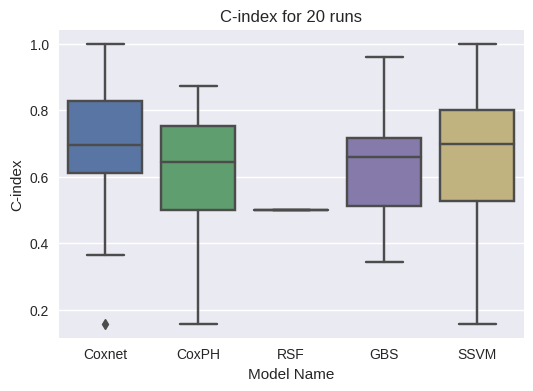

In [ ]:
# Visualise results

name = ['Coxnet', 'CoxPH', 'RSF', 'GBS', 'SSVM']
cv_res = []

for i in range(0,5):
    for c in c_index_list[i]:
        cv_res.append([name[i],c])

c_plot = pd.DataFrame(cv_res, columns=['Model Name','C-index'])

plt.subplots(figsize=(6,4))
ax = sns.boxplot(x="Model Name", y="C-index", data=c_plot)
plt.title('C-index for 20 runs')

In [ ]:
## Fine tune best performing model 

#Prepare hyperparameter  grid for  hyperparameter tuning
Coxnet_param_grid = {'alpha_min_ratio': [0.01, 0.001, 0.0001],
              'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
              'n_alphas': [50, 100, 150],
              'max_iter': [10000, 50000, 100000]}

In [ ]:
# Hyperparameter tuning with nested cross-validation

# Get copies of the dataset
Xg = X_mrmr_g
Yg = Y

# reset the index for data split
Xg = Xg.reset_index(drop=True)

# define the outer cross-validation loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# loop over the outer folds
outer_scores = []

for train_index, test_index in outer_cv.split(Xg, Yg):
    X_train, X_test = Xg.iloc[train_index], Xg.iloc[test_index]
    y_train, y_test = Yg[train_index], Yg[test_index]
    
    # define the inner cross-validation loop to tune the hyperparameters
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(CoxnetSurvivalAnalysis(), Coxnet_param_grid, cv=inner_cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # use the best hyperparameters to fit the model
    model = CoxnetSurvivalAnalysis(**grid_search.best_params_)
    model.fit(X_train, y_train)
    
    # evaluate the model on the test set
    score = model.score(X_test, y_test)
    outer_scores.append(score)

# print the mean score across the outer folds
print("Mean C-index: {:.3f}".format(np.mean(outer_scores)))

Mean C-index: 0.579


In [ ]:
# Print attributes from grid search
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: ", grid_search.best_score_)

Best hyperparameters:  {'alpha_min_ratio': 0.01, 'l1_ratio': 0.1, 'max_iter': 10000, 'n_alphas': 50}
Best mean cross-validation score:  0.764047619047619


In [ ]:
# Get best estimator from grid search
genex_model = grid_search.best_estimator_

In [ ]:
# Use the trained model to make predictions on the test set
y_pred = genex_model.predict(X_test)

In [ ]:
# Calculate the concordance index to evaluate the model's performance
ci = concordance_index_censored(y_test['Event'], y_test['Time'], y_pred)
print("Concordance index: {:.3f}".format(ci[0]))

Concordance index: 0.697


**Derive the relative risk interpretation from coefficients of features subset returned from model, by using cross-validation to determine which regularization penalty strength (alpha) generalizes best.**

In [ ]:
"""
We can use cross-validation to determine which regularization penalty strength (alpha) generalizes best,
and the relative risk interpretation from coefficients of features subset returned. 
"""

# Make pipeline for evaluating model
# Fit a penalized Cox model to the whole data

coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.1, alpha_min_ratio=0.01, max_iter=10000, n_alphas=50)
)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xg, Yg)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.1,
                                        max_iter=10000, n_alphas=50))])

In [ ]:
# Retrieve the estimated set of alphas
# Use the estimated set of alphas to perform 5 fold cross-validation to estimate performance in terms of concordance index for each aplha

estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.1, alpha_min_ratio=0.01, max_iter=10000, n_alphas=50)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1).fit(Xg, Yg)

cv_results = pd.DataFrame(gcv.cv_results_)

In [ ]:
# Get best regularization penalty strength (alpha)

gcv.best_params_

{'coxnetsurvivalanalysis__alphas': [0.027877928275810624]}

In [ ]:
# Get value of best regularization penalty strength (alpha)

gcv.best_params_["coxnetsurvivalanalysis__alphas"][0]

0.027877928275810624

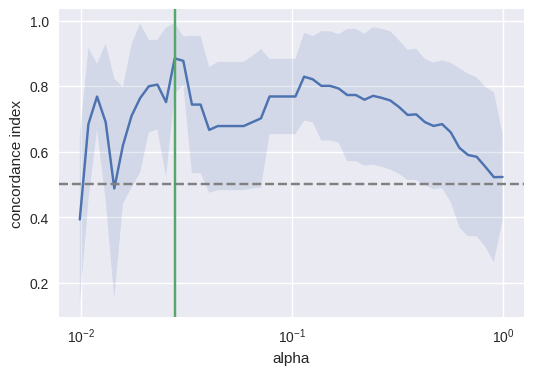

In [ ]:
# Visualize results by plotting the mean concordance index and its standard deviation across all folds for each alpha
# Best alpha value indicated by the green line

alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [ ]:
# Get best estimator with the best alpha value
gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, alphas=[0.027877928275810624],
                       l1_ratio=0.1, max_iter=10000, n_alphas=50)

Number of non-zero coefficients: 42


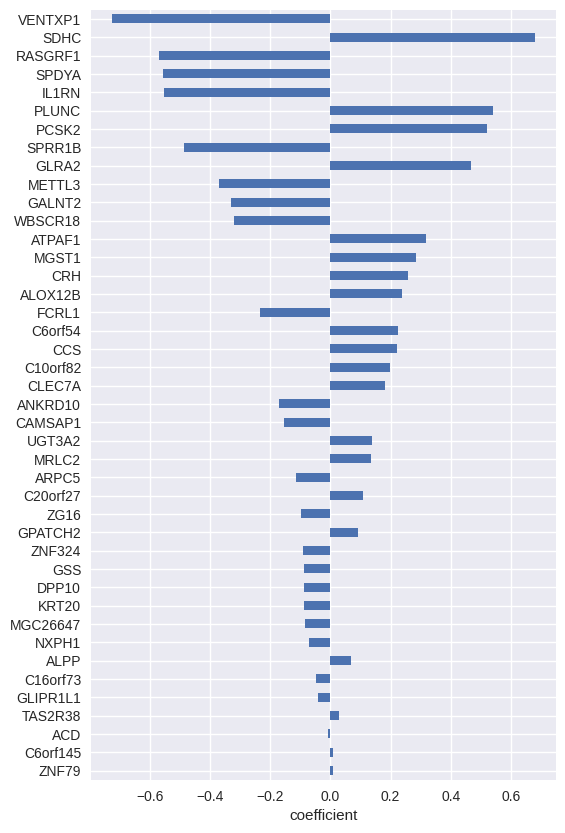

In [ ]:
# Plot to show selected risk factors and their level of importance
# Select features with non-zero coefficients
# Most important risk factors identified are 'VENTXP1' and 'SDHC'

best_gene_data_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_gene_data_model.coef_,
    index=Xg.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

Xg_non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = Xg_non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 10))
Xg_non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [ ]:
# Get relative risk of risk factors with exponetial of coefficients 

"""
Cox model: h(t|xᵢ) = h₀(t)exp(βxᵢ) 
where exp(β) indicates the relative risk of adverse event given by a risk factor (covariate xᵢ),
For each covariate xᵢ, we can observe its coefficient β and relative risk exp(β).
exp(β) > 1 : an increased risk of event (death) [Most potent risk factor: SDHC] 
exp(β) < 1 : a reduced risk of event [Most potent risk factor: VENTXP1] 
"""

df = pd.DataFrame({
    'Risk Factor': Xg.columns,
    'Coefficient [β]': best_gene_data_model.coef_.T[0],
    'Relative Risk [exp(β)]': np.exp(best_gene_data_model.coef_).T[0]
})

# Round results to 3 decimal places
df = df.round({'Coefficient [β]': 3, 'Relative Risk [exp(β)]': 3})

# Sort by absolute value of coefficients
df = df.iloc[abs(df['Coefficient [β]']).argsort()[::-1]]

# Reset index
df = df.reset_index(drop=True)

df.head(10)

,Risk Factor,Coefficient [β],Relative Risk [exp(β)]
0,VENTXP1,-0.724,0.485
1,SDHC,0.679,1.972
2,RASGRF1,-0.570,0.565
3,SPDYA,-0.555,0.574
4,IL1RN,-0.551,0.576
5,PLUNC,0.539,1.714
6,PCSK2,0.521,1.683
7,SPRR1B,-0.485,0.616
8,GLRA2,0.469,1.598
9,METTL3,-0.368,0.692


**Feature importance with SHAP values.**

In [ ]:
# Create a SHAP explainer object using the fitted model and the training data
explainer = shap.Explainer(best_gene_data_model.predict, X_train)

In [ ]:
# Calculate the SHAP values for a set of test instances
shap_values = explainer(X_test)

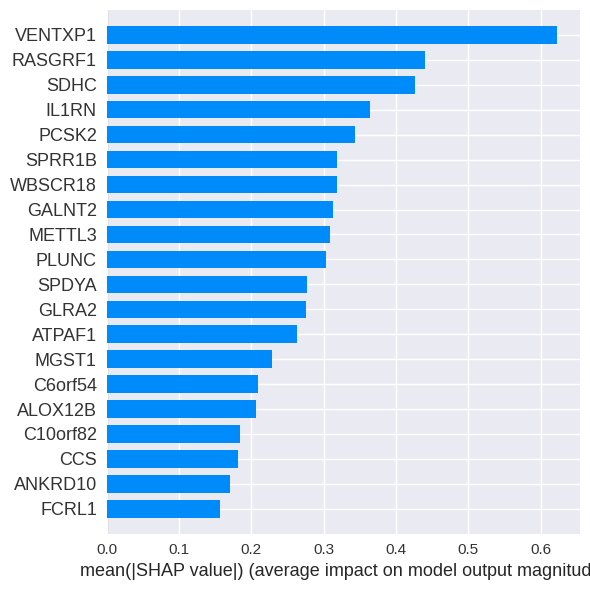

In [ ]:
# Plot the SHAP summary plot to visualize the overall feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(6,6))

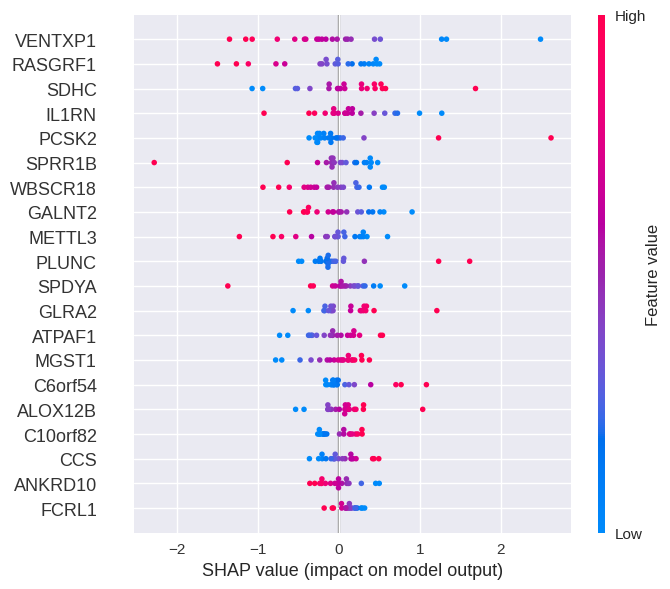

In [ ]:
# SHAP summary plot combining feature importance with feature effects
shap.summary_plot(shap_values, plot_size=(7,6))

### **Experiment 3:** Survival Analysis with Concatenated Data (Late Integration)

In [ ]:
#Check features in fluxes data model with non zero coefficients
Xf_non_zero_coefs.index

Index(['fluxes14', 'fluxes17', 'fluxes24', 'fluxes29', 'fluxes34', 'fluxes71',
       'fluxes77', 'fluxes78', 'fluxes82', 'fluxes88', 'fluxes95', 'fluxes104',
       'fluxes107', 'fluxes109', 'fluxes115', 'fluxes117', 'fluxes119',
       'fluxes123', 'fluxes152', 'fluxes156', 'fluxes159', 'fluxes161',
       'fluxes167', 'fluxes171', 'fluxes174', 'fluxes180', 'fluxes181',
       'fluxes182', 'fluxes183', 'fluxes196', 'fluxes208', 'fluxes217',
       'fluxes223', 'fluxes225', 'fluxes226', 'fluxes231', 'fluxes237',
       'fluxes239'],
      dtype='object')

In [ ]:
#Check features in gene expression data model with non zero coefficients
Xg_non_zero_coefs.index

Index(['CCS', 'ARPC5', 'ANKRD10', 'ALOX12B', 'C10orf82', 'VENTXP1', 'ALPP',
       'MRLC2', 'ZNF79', 'GSS', 'PLUNC', 'ACD', 'ATPAF1', 'ZNF324', 'PCSK2',
       'KRT20', 'CAMSAP1', 'GLIPR1L1', 'UGT3A2', 'FCRL1', 'NXPH1', 'RASGRF1',
       'GALNT2', 'TAS2R38', 'ZG16', 'SPDYA', 'METTL3', 'WBSCR18', 'DPP10',
       'GPATCH2', 'CLEC7A', 'C16orf73', 'SPRR1B', 'GLRA2', 'CRH', 'C20orf27',
       'C6orf145', 'SDHC', 'IL1RN', 'C6orf54', 'MGST1', 'MGC26647'],
      dtype='object')

In [ ]:
# Select features with non zero coefficients from fluxes data model
df_Xf = Xf.loc[:, list(Xf_non_zero_coefs.index)]

#Check shape of predictor variables
df_Xf.shape            

(105, 38)

In [ ]:
# Select features with non zero coefficients from fluxes data model
df_Xg = Xg.loc[:, list(Xg_non_zero_coefs.index)]

#Check shape of  predictor variables
df_Xg.shape    

(105, 42)

In [ ]:
# Concatenate the selected gene expression and fluxes dataframes
X_concat = pd.concat([df_Xg, df_Xf], axis=1)

#Check shape of concatenated  predictor variables
X_concat.shape

(105, 80)

In [ ]:
# Hyperparameter tuning with nested cross-validation for concatenated data

# Get copies of the dataset
Xc = X_concat
Yc = Y

# reset the index for data split
Xc = Xc.reset_index(drop=True)

# define the outer cross-validation loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# loop over the outer folds
outer_scores = []

for train_index, test_index in outer_cv.split(Xc, Yc):
    X_train, X_test = Xc.iloc[train_index], Xc.iloc[test_index]
    y_train, y_test = Yc[train_index], Yc[test_index]
    
    # define the inner cross-validation loop to tune the hyperparameters
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(CoxnetSurvivalAnalysis(), Coxnet_param_grid, cv=inner_cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # use the best hyperparameters to fit the model
    model = CoxnetSurvivalAnalysis(**grid_search.best_params_)
    model.fit(X_train, y_train)
    
    # evaluate the model on the test set
    score = model.score(X_test, y_test)
    outer_scores.append(score)

# print the mean score across the outer folds
print("Mean C-index: {:.3f}".format(np.mean(outer_scores)))

Mean C-index: 0.610


In [ ]:
# Print attributes from grid search
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: ", grid_search.best_score_)

Best hyperparameters:  {'alpha_min_ratio': 0.01, 'l1_ratio': 0.1, 'max_iter': 10000, 'n_alphas': 50}
Best mean cross-validation score:  0.744047619047619


In [ ]:
# Get best estimator from grid search
concat_data_model = grid_search.best_estimator_

In [ ]:
# Use the trained model to make predictions on the test set
y_pred = concat_data_model.predict(X_test)

In [ ]:
# Calculate the concordance index to evaluate the model's performance
ci = concordance_index_censored(y_test['Event'], y_test['Time'], y_pred)
print("Concordance index: {:.3f}".format(ci[0]))

Concordance index: 0.727


**Derive the relative risk interpretation from coefficients of features subset returned from model, by using cross-validation to determine which regularization penalty strength (alpha) generalizes best.**

In [ ]:
"""
We can use cross-validation to determine which regularization penalty strength (alpha) generalizes best,
and the relative risk interpretation from coefficients of features subset returned. 
"""

# Make pipeline for evaluating model
# Fit a penalized Cox model to the whole data

coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.1, alpha_min_ratio=0.01, max_iter=10000, n_alphas=50)
)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xc, Yc)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.1,
                                        max_iter=10000, n_alphas=50))])

In [ ]:
# Retrieve the estimated set of alphas
# Use the estimated set of alphas to perform 5 fold cross-validation to estimate performance in terms of concordance index for each aplha

estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.1, alpha_min_ratio=0.01, max_iter=10000, n_alphas=50)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1).fit(Xc, Yc)

cv_results = pd.DataFrame(gcv.cv_results_)

In [ ]:
# Get best regularization penalty strength (alpha)

gcv.best_params_

{'coxnetsurvivalanalysis__alphas': [0.0861105602377961]}

In [ ]:
# Get value of best regularization penalty strength (alpha)

gcv.best_params_["coxnetsurvivalanalysis__alphas"][0]

0.0861105602377961

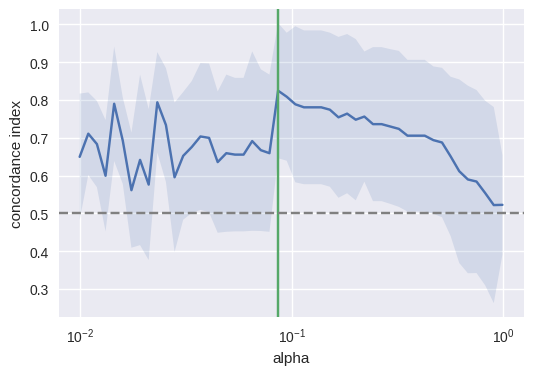

In [ ]:
# Visualize results by plotting the mean concordance index and its standard deviation across all folds for each alpha
# Best alpha value indicated by the green line

alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [ ]:
# Get best estimator with the best alpha value
gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, alphas=[0.0861105602377961],
                       l1_ratio=0.1, max_iter=10000, n_alphas=50)

Number of non-zero coefficients: 34


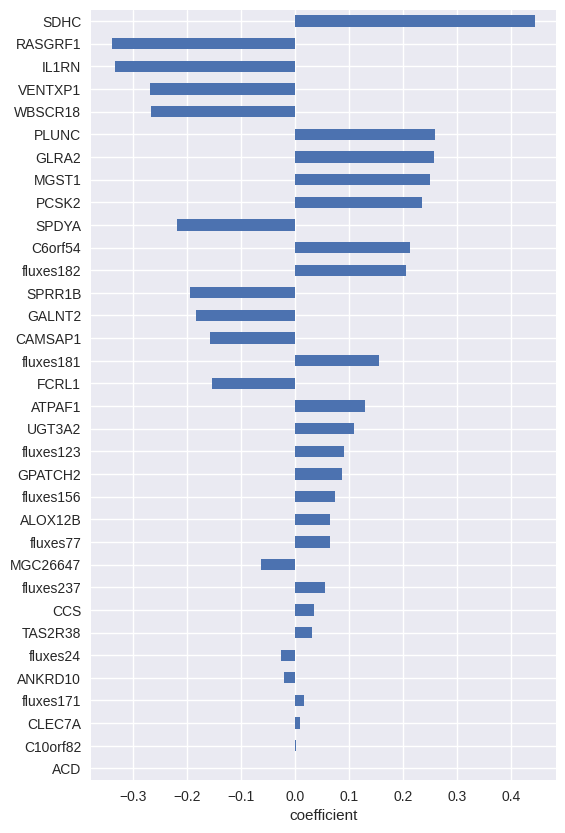

In [ ]:
# Plot to show selected risk factors and their level of importance

best_concat_data_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_concat_data_model.coef_,
    index=Xc.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 10))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

**Feature importance with SHAP values.**

In [ ]:
# Create a SHAP explainer object using the fitted model and the training data
explainer = shap.Explainer(best_concat_data_model.predict, X_train)

In [ ]:
# Calculate the SHAP values for a set of test instances
shap_values = explainer(X_test)

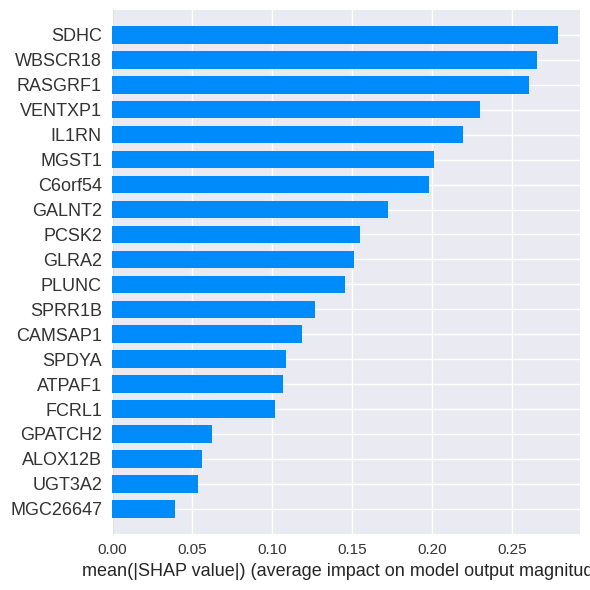

In [ ]:
# Plot the SHAP summary plot to visualize the overall feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(6,6))

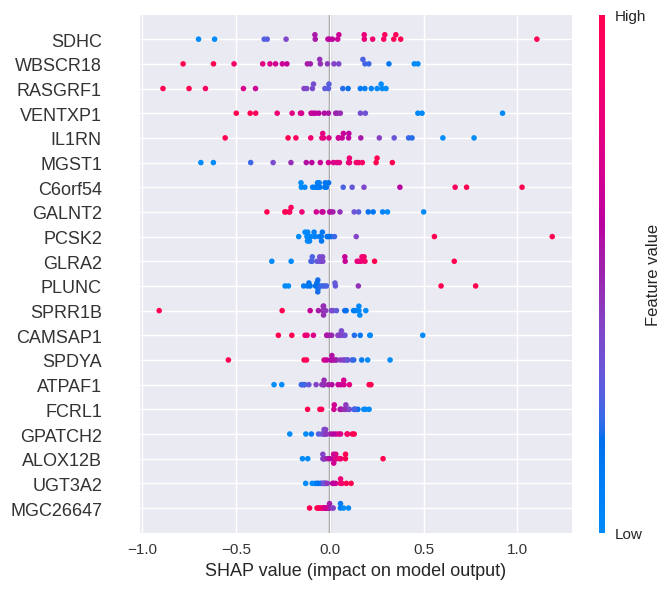

In [ ]:
# SHAP summary plot combining feature importance with feature effects
shap.summary_plot(shap_values, plot_size=(7,6))